In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
import json
import h5py

# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
f = h5py.File("/media/dev/New Volume/projects/DS LITE/static_dataset_lite.hdf5", "r")
cuda = torch.device('cuda')
frame_size = 10

In [3]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Actor, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x

In [4]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [5]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [10]:
debug_state = None
debug_action = None
debug_gen_action = None
debug_target_value = []


def ddpg_update(batch, gamma = 0.99, min_value=-np.inf, max_value=np.inf,
           soft_tau=1e-2, debug=False, learn=True):
    
    state, action, reward, next_state, done = batch
    
    if not learn:
        [net.eval() for net in nets]
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    gen_action = policy_net(state)
    policy_loss = -value_net(state, gen_action).mean()
    
    next_action = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)
    
    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
    if debug:
        global debug_state
        global debug_action
        global debug_gen_action
        debug_state = state
        debug_action = action
        debug_gen_action = gen_action 

    if not learn:
        # used for testing
        [net.train() for net in nets]
        losses = [value_loss.item(), policy_loss.item()]
        return losses
    
    #policy_optimizer.zero_grad()
    #policy_loss.backward()
    #torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
    #policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    torch.nn.utils.clip_grad_norm_(value_net.parameters(), -1, 1)
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
    losses = [value_loss.item(), policy_loss.item()]
    return losses

In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

def run_tests():
    test_batch = [f[key][n_batches-1*batch_size:(n_batches)*batch_size] for key in
                 ['state', 'action', 'reward', 'next_state', 'done']]
    test_batch = prepare_batch(*test_batch)
    losses = ddpg_update(test_batch, debug=True, learn=False)
    return losses
    

# value, policy, step
def plot(value_losses, policy_losses, test=True):
    global test_losses
    if test:
        test_ = run_tests()
        test_losses[0].append(test_[0])
        test_losses[1].append(test_[1])
        test_losses[2].append(len(value_losses))
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('value')
    plt.plot(value_losses, label='train')
    plt.plot(test_losses[2], test_losses[0], label='test')
    plt.legend()
    plt.subplot(132)
    plt.title('policy')
    plt.plot(policy_losses, label='train')
    plt.plot(test_losses[2], test_losses[1], '-r', label='test')
    plt.legend()
    plt.show()

In [15]:
test_losses = [[], [], []]
value_net  = Critic(256, 128, 320).to(cuda)
policy_net = Actor(256, 128, 192).to(cuda)

target_value_net = Critic(256, 128, 320).to(cuda)
target_policy_net = Actor(256, 128, 192).to(cuda)

nets =[value_net, policy_net, target_value_net, target_policy_net]

soft_update(value_net, target_value_net, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)


value_criterion = nn.MSELoss()

policy_lr = 1e-5
value_lr  = 1e-5

value_optimizer = optim.RMSprop(value_net.parameters(), lr=value_lr)
policy_optimizer = optim.RMSprop(policy_net.parameters(), lr=policy_lr)

In [16]:
value_losses = []
policy_losses = []

n_epochs = 100
batch_size = 5000
n_batches = (f['state'].shape[0] // batch_size)

batch_bar = tqdm(total=n_batches)
epoch_bar = tqdm(total=n_epochs)

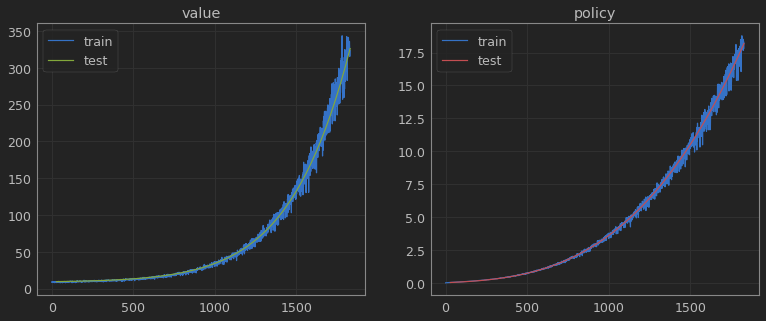

KeyboardInterrupt: 

In [17]:
def prepare_batch(*args):
    args = [torch.tensor(np.array(arg).astype(np.float)).to(cuda).float() for arg in args]
    return args

DEBUG = True

batch = []
plot_every = 30
step = 1
policy_update = 2

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for i in range(n_batches-1):
        step += 1
        batch_bar.update(1)
        batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['state', 'action', 'reward', 'next_state', 'done']]
        batch = prepare_batch(*batch)
        
        loss = ddpg_update(batch, debug=DEBUG)
        value_losses.append(loss[0])
        policy_losses.append(loss[1])
        
        batch = []
        
        # debug plotting
        if step % plot_every == 0:
            plot(value_losses, policy_losses)
            
    batch_bar.refresh()

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


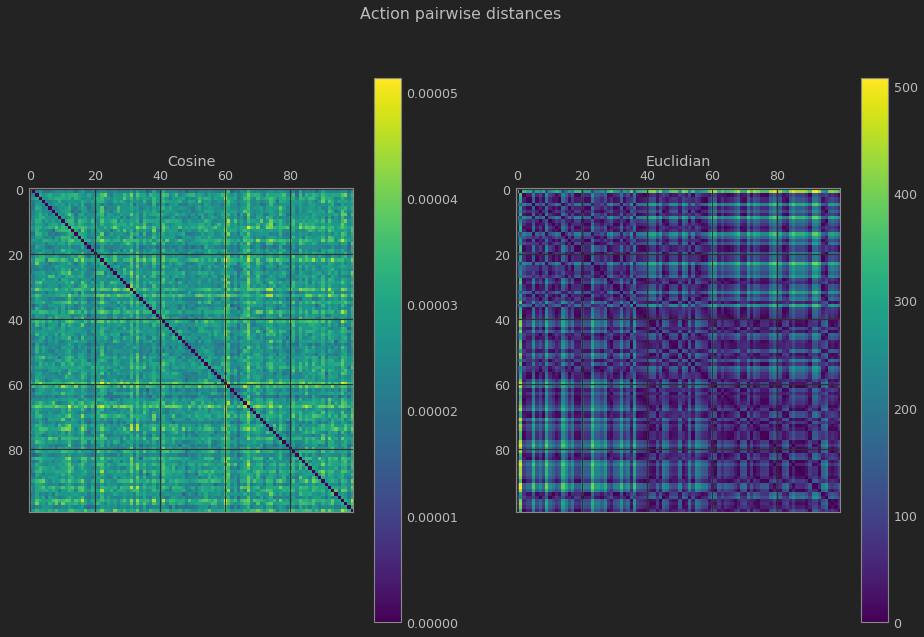

In [26]:
from scipy.spatial import distance

embs = debug_gen_action[:100].detach().cpu().numpy()
similarity_matrix_cos = distance.cdist(embs, embs, 'cosine')
similarity_matrix_euc = distance.cdist(embs, embs, 'euclidean')

fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(121)
cax = ax.matshow(similarity_matrix_cos)
fig.colorbar(cax)
ax.set_title('Cosine')

ax = fig.add_subplot(122)
cax = ax.matshow(similarity_matrix_euc)
fig.colorbar(cax)
ax.set_title('Euclidian')


fig.suptitle('Action pairwise distances')
fig.show()